Satisfacción
General
Mallorca
Málaga
Valencia

In [1]:
%pip install sqlalchemy pyodbc matplotlib seaborn plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Database connection configuration
# Replace with your actual credentials
server = 'upgrade-abnb-server.database.windows.net'
database = 'Upgrade_Abnb'
username = 'vmabnbserver'  # Replace with actual username
password = 'JWkWW8Bg%>jy,Xj!'  # Replace with actual password

# Function to test ODBC drivers and create connection
def create_db_connection():
    """Create database connection with fallback driver options"""
    drivers = [
        'ODBC Driver 18 for SQL Server',
        'ODBC Driver 17 for SQL Server',
        'ODBC Driver 13 for SQL Server',
        'SQL Server Native Client 11.0',
        'SQL Server'
    ]
    
    # Test available drivers
    available_drivers = [driver for driver in pyodbc.drivers() if any(d in driver for d in ['SQL Server', 'ODBC'])]
    print(f"Available ODBC drivers: {available_drivers}")
    
    for driver in drivers:
        if driver in available_drivers:
            try:
                connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&TrustServerCertificate=yes&Encrypt=yes'
                engine = create_engine(connection_string)
                # Test connection
                with engine.connect() as conn:
                    conn.execute(sqlalchemy.text("SELECT 1"))
                print(f"Successfully connected using driver: {driver}")
                return engine, connection_string
            except Exception as e:
                print(f"Failed with driver {driver}: {str(e)}")
                continue
    
    # If all drivers fail, try without encryption
    for driver in drivers:
        if driver in available_drivers:
            try:
                connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&TrustServerCertificate=yes'
                engine = create_engine(connection_string)
                # Test connection
                with engine.connect() as conn:
                    conn.execute(sqlalchemy.text("SELECT 1"))
                print(f"Successfully connected using driver (no encryption): {driver}")
                return engine, connection_string
            except Exception as e:
                print(f"Failed with driver {driver} (no encryption): {str(e)}")
                continue
    
    raise Exception("Could not establish database connection with any available driver")

# Create connection engine
engine, connection_string = create_db_connection()

# Function to execute queries and return DataFrames
def query_to_df(query, engine=engine):
    """Execute SQL query and return DataFrame"""
    return pd.read_sql(query, engine)

# Load main dataset
query = "SELECT * FROM [dbo].[listings_completo]"
df_listings = query_to_df(query)

# Configure matplotlib and seaborn for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display basic information
print("=== DATABASE CONNECTION ESTABLISHED ===")
print(f"Connected to: {database}")
print(f"DataFrame shape: {df_listings.shape}")
print(f"Columns: {list(df_listings.columns)}")
print("\n=== FIRST 5 ROWS ===")
print(df_listings.head())
print("\n=== DATA TYPES ===")
print(df_listings.dtypes)
print("\n=== MISSING VALUES ===")
print(df_listings.isnull().sum())

Available ODBC drivers: ['SQL Server']
Successfully connected using driver: SQL Server
=== DATABASE CONNECTION ESTABLISHED ===
Connected to: Upgrade_Abnb
DataFrame shape: (1630091, 63)
Columns: ['listing_id', 'id_x', 'date', 'reviewer_id', 'reviewer_name', 'id_y', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d

Comparacion super host vs regular

Original records: 25,181
After removing price outliers: 22,561
Outliers removed: 2,620 (10.4%)

Available cities: Valencia, Málaga, Mallorca

Analyzing:  - All Cities
Records in analysis: 22,561

=== SUPERHOST vs REGULAR HOST COMPARISON - All Cities ===
                           review_scores_rating                     \
                                           mean median   std count   
origen   host_is_superhost                                           
Mallorca Not_defined                       4.83   4.88  0.19   106   
         f                                 4.63   4.72  0.41  5707   
         t                                 4.85   4.89  0.20  2617   
Málaga   Not_defined                       4.68   4.79  0.41   208   
         f                                 4.57   4.67  0.46  4995   
         t                                 4.83   4.86  0.15  2348   
Valencia Not_defined                       4.69   4.78  0.32   207   
         f                                 4.5

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_26632\167725432.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1,0].boxplot(satisfaction_data, labels=['Regular Host', 'Superhost'], patch_artist=True)


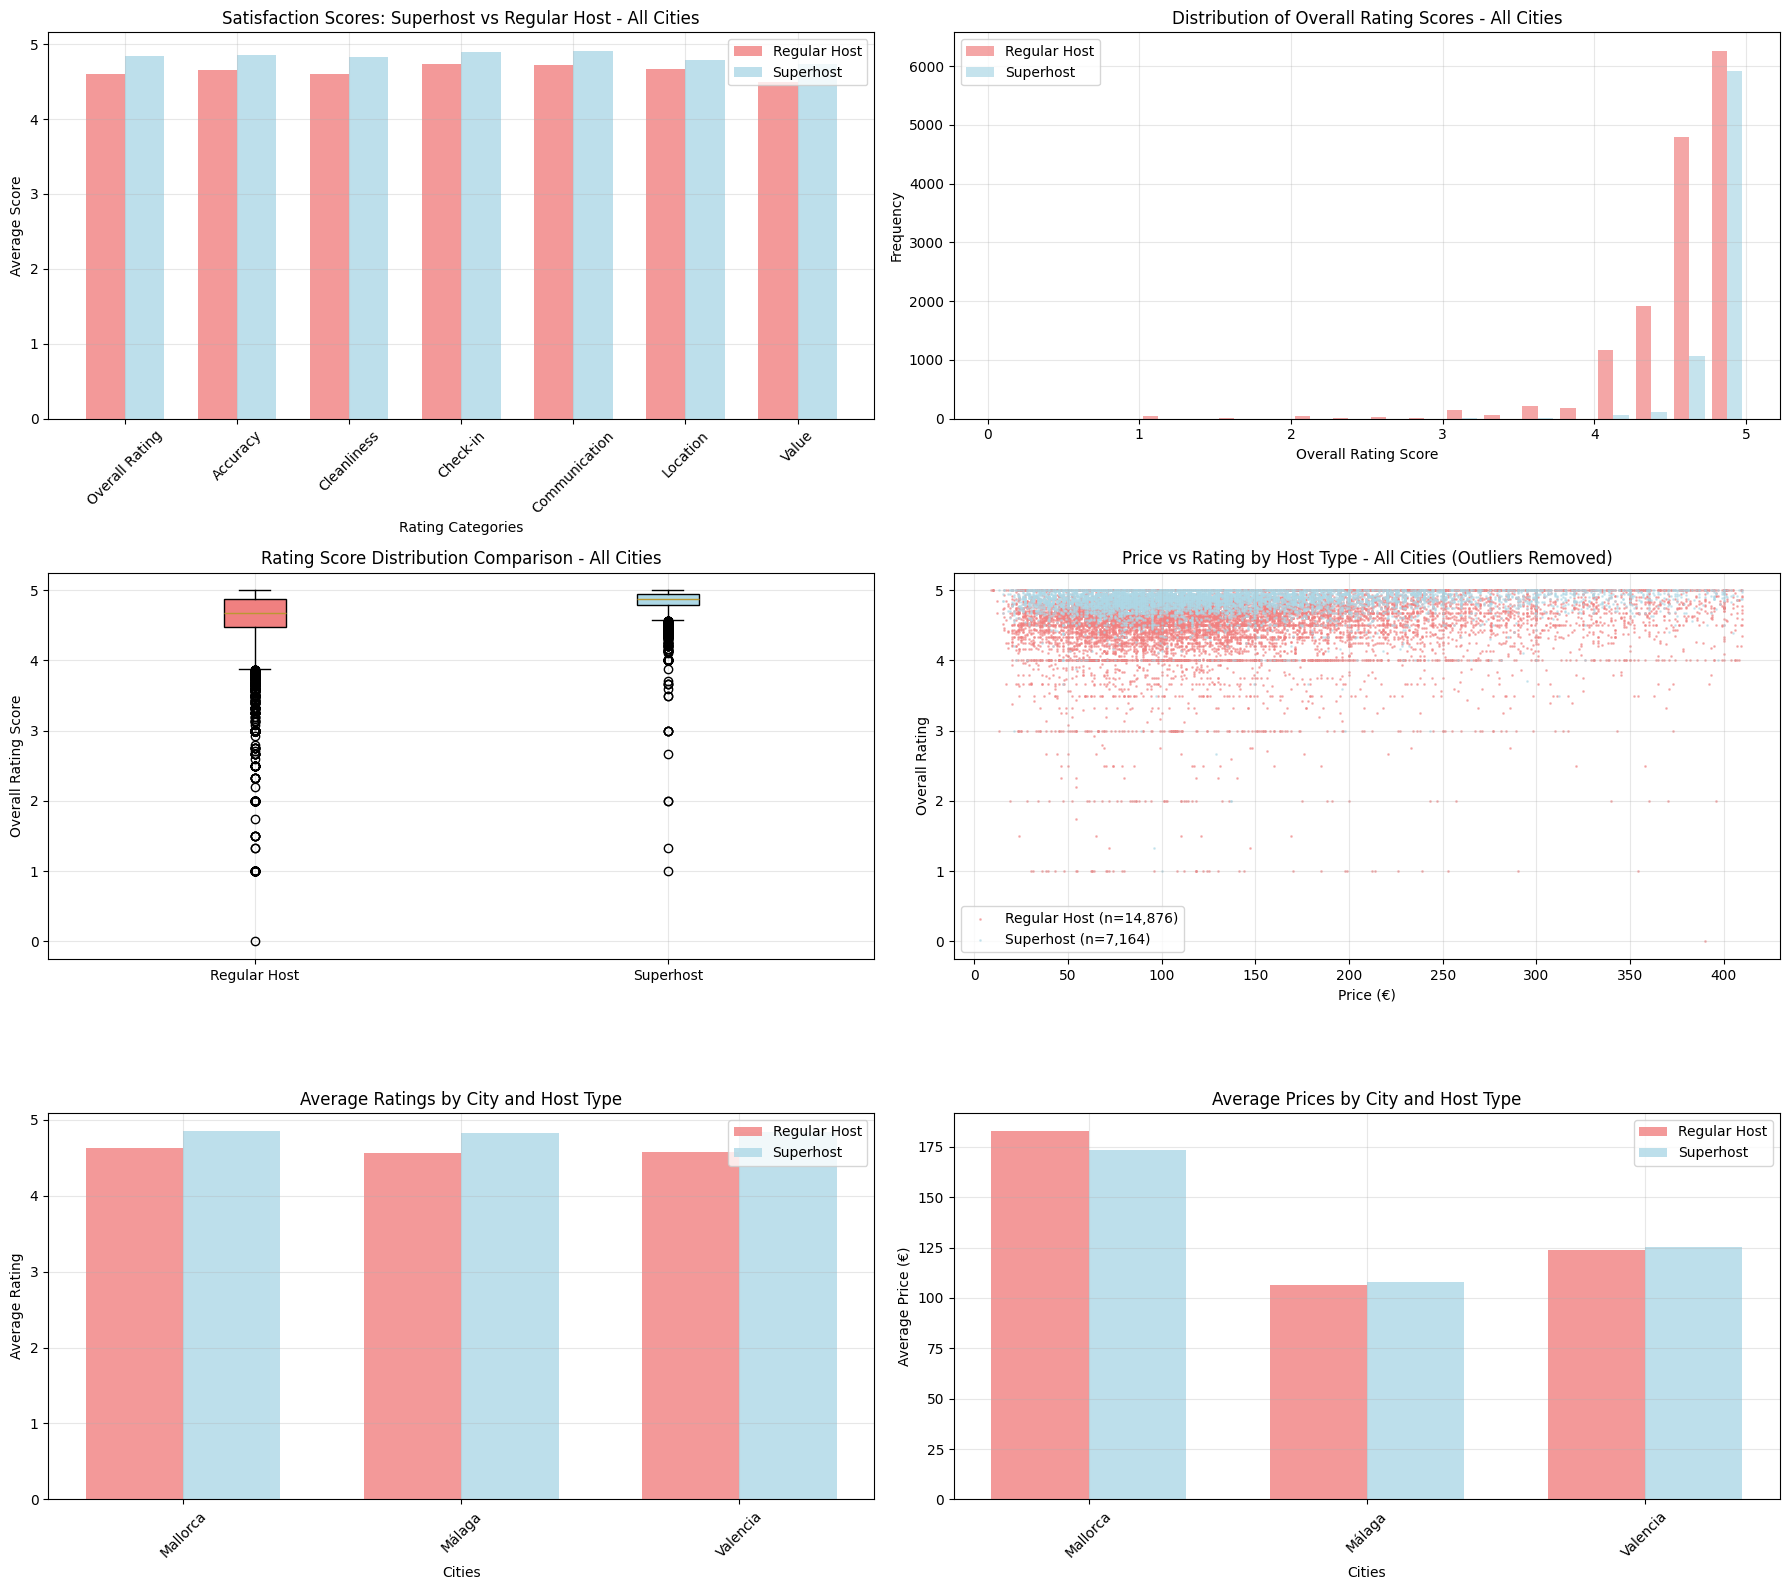


=== STATISTICAL SIGNIFICANCE TEST - All Cities ===
T-statistic: 44.4619
P-value: 0.000000
Statistically significant difference: Yes

=== KEY INSIGHTS - All Cities ===
• Superhosts have 5.3% higher ratings on average
• Superhosts charge -2.2% less on average
• Superhosts have 116.5% more reviews on average


In [3]:
# Calculate superhost vs regular host analysis for overall satisfaction
# First, let's get unique listings to avoid duplicates in our analysis
df_unique = df_listings.drop_duplicates(subset=['listing_id'])

# Remove outliers for better analysis
def remove_outliers(df, column, method='iqr'):
    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove price outliers
df_clean = remove_outliers(df_unique, 'price')
print(f"Original records: {len(df_unique):,}")
print(f"After removing price outliers: {len(df_clean):,}")
print(f"Outliers removed: {len(df_unique) - len(df_clean):,} ({((len(df_unique) - len(df_clean))/len(df_unique)*100):.1f}%)")

# Get unique cities for analysis
cities = df_clean['origen'].unique()
print(f"\nAvailable cities: {', '.join(cities)}")

# User can modify this to analyze specific city or 'All' for combined analysis
city_filter = 'All'  # Options: 'All', 'Valencia', 'Barcelona', 'Madrid', etc.

if city_filter != 'All':
    df_analysis = df_clean[df_clean['origen'] == city_filter]
    title_suffix = f" - {city_filter}"
else:
    df_analysis = df_clean
    title_suffix = " - All Cities"

print(f"\nAnalyzing: {title_suffix}")
print(f"Records in analysis: {len(df_analysis):,}")

# Create superhost comparison analysis
superhost_analysis = df_analysis.groupby(['origen', 'host_is_superhost']).agg({
    'review_scores_rating': ['mean', 'median', 'std', 'count'],
    'review_scores_accuracy': 'mean',
    'review_scores_cleanliness': 'mean', 
    'review_scores_checkin': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_location': 'mean',
    'review_scores_value': 'mean',
    'number_of_reviews': 'mean',
    'price': 'mean'
}).round(2)

print(f"\n=== SUPERHOST vs REGULAR HOST COMPARISON{title_suffix} ===")
print(superhost_analysis)

# Overall comparison (aggregated across cities if All selected)
overall_comparison = df_analysis.groupby('host_is_superhost').agg({
    'review_scores_rating': ['mean', 'median', 'std', 'count'],
    'review_scores_accuracy': 'mean',
    'review_scores_cleanliness': 'mean', 
    'review_scores_checkin': 'mean',
    'review_scores_communication': 'mean',
    'review_scores_location': 'mean',
    'review_scores_value': 'mean',
    'number_of_reviews': 'mean',
    'price': 'mean'
}).round(2)

print(f"\n=== OVERALL COMPARISON{title_suffix} ===")
print(overall_comparison)

# Create a summary comparison table
comparison_summary = pd.DataFrame({
    'Regular Host': [
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_accuracy'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_cleanliness'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_checkin'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_communication'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_location'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_value'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['number_of_reviews'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 'f']['price'].mean()
    ],
    'Superhost': [
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_accuracy'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_cleanliness'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_checkin'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_communication'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_location'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_value'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['number_of_reviews'].mean(),
        df_analysis[df_analysis['host_is_superhost'] == 't']['price'].mean()
    ]
}, index=['Overall Rating', 'Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value', 'Avg Reviews', 'Avg Price'])

# Calculate differences
comparison_summary['Difference'] = comparison_summary['Superhost'] - comparison_summary['Regular Host']
comparison_summary['% Difference'] = ((comparison_summary['Superhost'] - comparison_summary['Regular Host']) / comparison_summary['Regular Host'] * 100).round(2)

print(f"\n=== DETAILED COMPARISON SUMMARY{title_suffix} ===")
print(comparison_summary.round(2))

# Count distribution
if city_filter == 'All':
    host_counts_by_city = df_analysis.groupby(['origen', 'host_is_superhost']).size().unstack(fill_value=0)
    print(f"\n=== HOST TYPE DISTRIBUTION BY CITY ===")
    for city in host_counts_by_city.index:
        regular = host_counts_by_city.loc[city, 'f']
        super_count = host_counts_by_city.loc[city, 't']
        total = regular + super_count
        print(f"{city}:")
        print(f"  Regular Hosts: {regular:,} ({regular/total*100:.1f}%)")
        print(f"  Superhosts: {super_count:,} ({super_count/total*100:.1f}%)")

host_counts = df_analysis['host_is_superhost'].value_counts()
print(f"\n=== OVERALL HOST TYPE DISTRIBUTION{title_suffix} ===")
print(f"Regular Hosts: {host_counts['f']:,} ({host_counts['f']/len(df_analysis)*100:.1f}%)")
print(f"Superhosts: {host_counts['t']:,} ({host_counts['t']/len(df_analysis)*100:.1f}%)")

# Visualization
if city_filter == 'All':
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall satisfaction comparison
categories = ['Overall Rating', 'Accuracy', 'Cleanliness', 'Check-in', 'Communication', 'Location', 'Value']
regular_scores = comparison_summary.loc[categories, 'Regular Host'].values
super_scores = comparison_summary.loc[categories, 'Superhost'].values

x = np.arange(len(categories))
width = 0.35

axes[0,0].bar(x - width/2, regular_scores, width, label='Regular Host', alpha=0.8, color='lightcoral')
axes[0,0].bar(x + width/2, super_scores, width, label='Superhost', alpha=0.8, color='lightblue')
axes[0,0].set_xlabel('Rating Categories')
axes[0,0].set_ylabel('Average Score')
axes[0,0].set_title(f'Satisfaction Scores: Superhost vs Regular Host{title_suffix}')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(categories, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribution of overall ratings
regular_ratings = df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].dropna()
super_ratings = df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].dropna()

axes[0,1].hist([regular_ratings, super_ratings], 
               bins=20, alpha=0.7, label=['Regular Host', 'Superhost'], 
               color=['lightcoral', 'lightblue'])
axes[0,1].set_xlabel('Overall Rating Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title(f'Distribution of Overall Rating Scores{title_suffix}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Box plot comparison
satisfaction_data = [regular_ratings, super_ratings]
box_plot = axes[1,0].boxplot(satisfaction_data, labels=['Regular Host', 'Superhost'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
box_plot['boxes'][1].set_facecolor('lightblue')
axes[1,0].set_ylabel('Overall Rating Score')
axes[1,0].set_title(f'Rating Score Distribution Comparison{title_suffix}')
axes[1,0].grid(True, alpha=0.3)

# 4. Price vs Rating scatter (without outliers)
regular_data = df_analysis[df_analysis['host_is_superhost'] == 'f']
super_data = df_analysis[df_analysis['host_is_superhost'] == 't']

axes[1,1].scatter(regular_data['price'], regular_data['review_scores_rating'], 
                 alpha=0.5, label=f'Regular Host (n={len(regular_data):,})', s=1, color='lightcoral')
axes[1,1].scatter(super_data['price'], super_data['review_scores_rating'], 
                 alpha=0.5, label=f'Superhost (n={len(super_data):,})', s=1, color='lightblue')
axes[1,1].set_xlabel('Price (€)')
axes[1,1].set_ylabel('Overall Rating')
axes[1,1].set_title(f'Price vs Rating by Host Type{title_suffix} (Outliers Removed)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. City comparison (only if analyzing all cities)
if city_filter == 'All':
    city_superhost_stats = df_analysis.groupby(['origen', 'host_is_superhost']).agg({
        'review_scores_rating': 'mean',
        'price': 'mean'
    }).unstack()
    
    city_names = city_superhost_stats.index
    x_cities = np.arange(len(city_names))
    
    regular_ratings_city = city_superhost_stats[('review_scores_rating', 'f')].values
    super_ratings_city = city_superhost_stats[('review_scores_rating', 't')].values
    
    axes[2,0].bar(x_cities - width/2, regular_ratings_city, width, 
                  label='Regular Host', alpha=0.8, color='lightcoral')
    axes[2,0].bar(x_cities + width/2, super_ratings_city, width, 
                  label='Superhost', alpha=0.8, color='lightblue')
    axes[2,0].set_xlabel('Cities')
    axes[2,0].set_ylabel('Average Rating')
    axes[2,0].set_title('Average Ratings by City and Host Type')
    axes[2,0].set_xticks(x_cities)
    axes[2,0].set_xticklabels(city_names, rotation=45)
    axes[2,0].legend()
    axes[2,0].grid(True, alpha=0.3)
    
    # 6. Price comparison by city
    regular_prices_city = city_superhost_stats[('price', 'f')].values
    super_prices_city = city_superhost_stats[('price', 't')].values
    
    axes[2,1].bar(x_cities - width/2, regular_prices_city, width, 
                  label='Regular Host', alpha=0.8, color='lightcoral')
    axes[2,1].bar(x_cities + width/2, super_prices_city, width, 
                  label='Superhost', alpha=0.8, color='lightblue')
    axes[2,1].set_xlabel('Cities')
    axes[2,1].set_ylabel('Average Price (€)')
    axes[2,1].set_title('Average Prices by City and Host Type')
    axes[2,1].set_xticks(x_cities)
    axes[2,1].set_xticklabels(city_names, rotation=45)
    axes[2,1].legend()
    axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance test
from scipy import stats

regular_ratings_clean = df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].dropna()
super_ratings_clean = df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].dropna()

t_stat, p_value = stats.ttest_ind(super_ratings_clean, regular_ratings_clean)

print(f"\n=== STATISTICAL SIGNIFICANCE TEST{title_suffix} ===")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")

print(f"\n=== KEY INSIGHTS{title_suffix} ===")
print(f"• Superhosts have {comparison_summary.loc['Overall Rating', '% Difference']:.1f}% higher ratings on average")
print(f"• Superhosts charge {comparison_summary.loc['Avg Price', '% Difference']:.1f}% {'more' if comparison_summary.loc['Avg Price', '% Difference'] > 0 else 'less'} on average")
print(f"• Superhosts have {comparison_summary.loc['Avg Reviews', '% Difference']:.1f}% {'more' if comparison_summary.loc['Avg Reviews', '% Difference'] > 0 else 'fewer'} reviews on average")

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_26632\1439343732.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[2,0].boxplot(satisfaction_box_data, labels=['Regular Host', 'Superhost'], patch_artist=True)


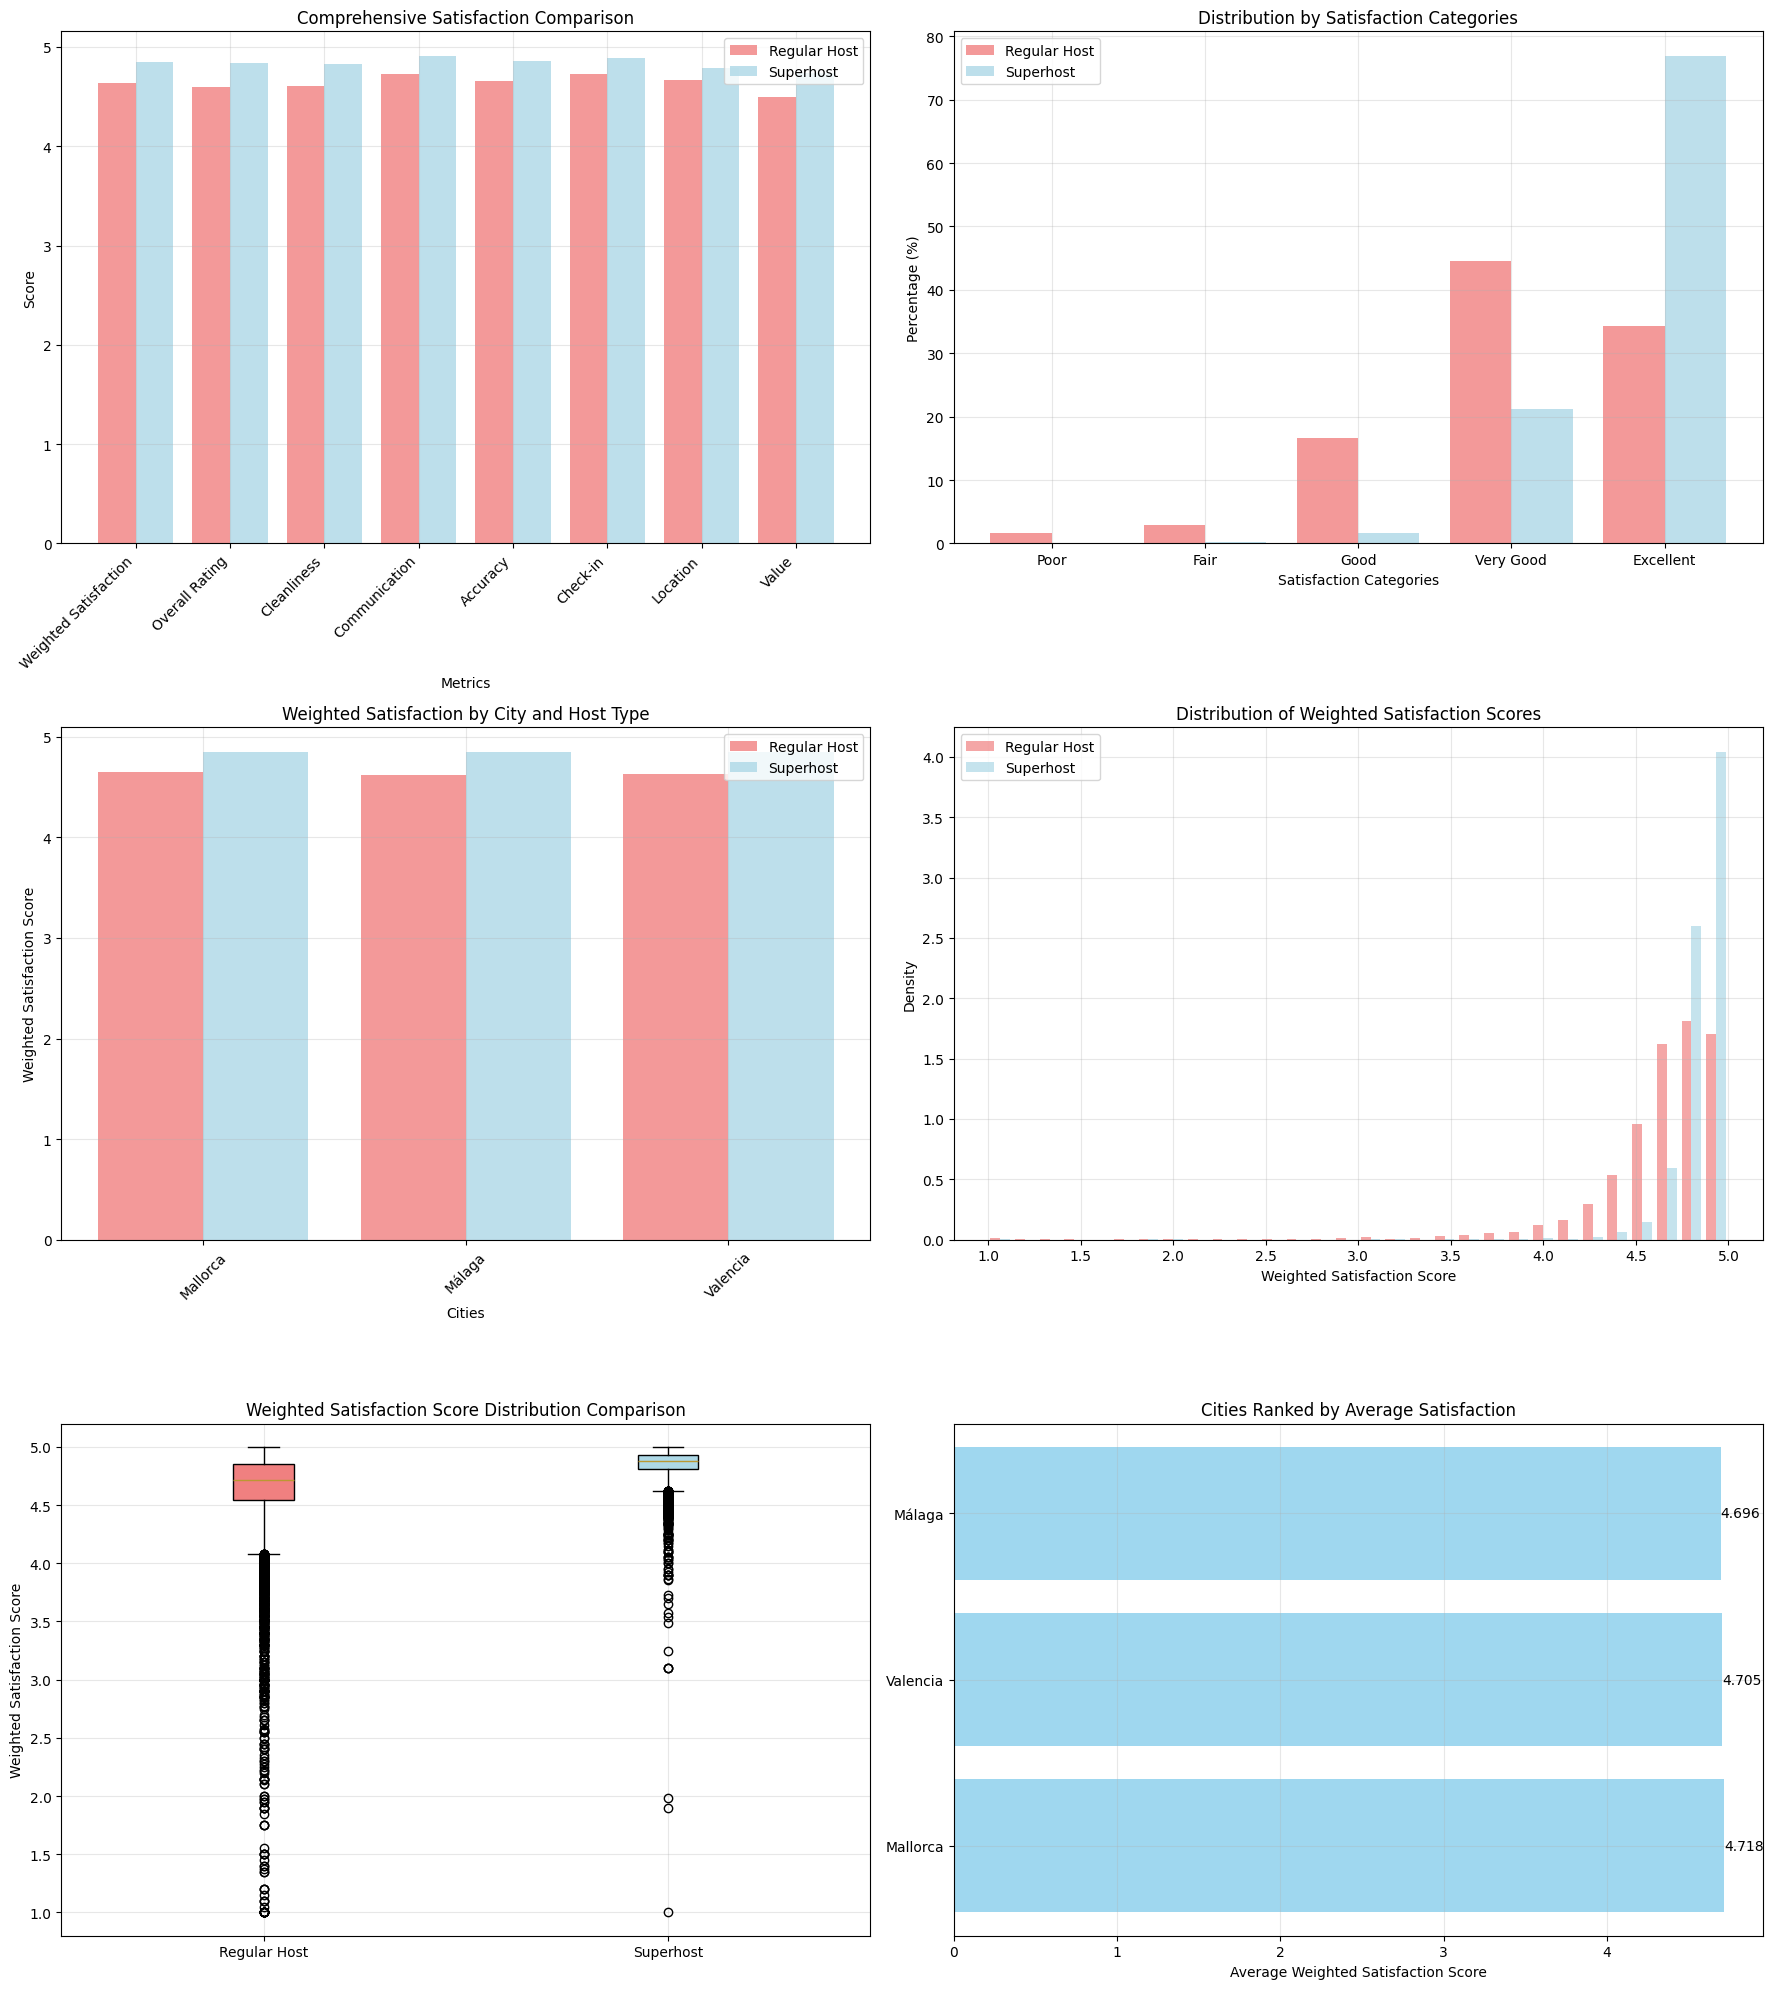


=== CREATING INTERACTIVE SATISFACTION VISUALIZATIONS ===



=== SATISFACTION ANALYSIS SUMMARY CHART ===
          Metric Weighted Satisfaction Overall Rating
Regular Host Avg                 4.637          4.595
   Superhost Avg                 4.849          4.841
      Difference                 0.212          0.245
   % Improvement                  4.6%           5.3%


In [9]:
# Create comprehensive visualizations for satisfaction analysis
fig, axes = plt.subplots(3, 2, figsize=(18, 20))

# 1. Weighted Satisfaction Comparison by Host Type
categories = ['Weighted Satisfaction', 'Overall Rating', 'Cleanliness', 'Communication', 'Accuracy', 'Check-in', 'Location', 'Value']
regular_weighted = [
    df_analysis[df_analysis['host_is_superhost'] == 'f']['weighted_satisfaction'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_cleanliness'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_communication'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_accuracy'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_checkin'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_location'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_value'].mean()
]

super_weighted = [
    df_analysis[df_analysis['host_is_superhost'] == 't']['weighted_satisfaction'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_cleanliness'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_communication'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_accuracy'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_checkin'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_location'].mean(),
    df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_value'].mean()
]

x_pos = np.arange(len(categories))
axes[0,0].bar(x_pos - 0.2, regular_weighted, 0.4, label='Regular Host', alpha=0.8, color='lightcoral')
axes[0,0].bar(x_pos + 0.2, super_weighted, 0.4, label='Superhost', alpha=0.8, color='lightblue')
axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Comprehensive Satisfaction Comparison')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(categories, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Satisfaction Category Distribution
satisfaction_categories = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
regular_dist = [
    satisfaction_percentages.loc['f', 'Poor'],
    satisfaction_percentages.loc['f', 'Fair'],
    satisfaction_percentages.loc['f', 'Good'],
    satisfaction_percentages.loc['f', 'Very Good'],
    satisfaction_percentages.loc['f', 'Excellent']
]
super_dist = [
    satisfaction_percentages.loc['t', 'Poor'],
    satisfaction_percentages.loc['t', 'Fair'],
    satisfaction_percentages.loc['t', 'Good'],
    satisfaction_percentages.loc['t', 'Very Good'],
    satisfaction_percentages.loc['t', 'Excellent']
]

x_cat = np.arange(len(satisfaction_categories))
axes[0,1].bar(x_cat - 0.2, regular_dist, 0.4, label='Regular Host', alpha=0.8, color='lightcoral')
axes[0,1].bar(x_cat + 0.2, super_dist, 0.4, label='Superhost', alpha=0.8, color='lightblue')
axes[0,1].set_xlabel('Satisfaction Categories')
axes[0,1].set_ylabel('Percentage (%)')
axes[0,1].set_title('Distribution by Satisfaction Categories')
axes[0,1].set_xticks(x_cat)
axes[0,1].set_xticklabels(satisfaction_categories)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Weighted Satisfaction by City and Host Type
city_weighted_data = df_analysis.groupby(['origen', 'host_is_superhost'])['weighted_satisfaction'].mean().unstack()
cities = city_weighted_data.index
regular_by_city = city_weighted_data['f'].values
super_by_city = city_weighted_data['t'].values

x_cities = np.arange(len(cities))
axes[1,0].bar(x_cities - 0.2, regular_by_city, 0.4, label='Regular Host', alpha=0.8, color='lightcoral')
axes[1,0].bar(x_cities + 0.2, super_by_city, 0.4, label='Superhost', alpha=0.8, color='lightblue')
axes[1,0].set_xlabel('Cities')
axes[1,0].set_ylabel('Weighted Satisfaction Score')
axes[1,0].set_title('Weighted Satisfaction by City and Host Type')
axes[1,0].set_xticks(x_cities)
axes[1,0].set_xticklabels(cities, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Distribution of Weighted Satisfaction Scores
regular_weighted_scores = df_analysis[df_analysis['host_is_superhost'] == 'f']['weighted_satisfaction']
super_weighted_scores = df_analysis[df_analysis['host_is_superhost'] == 't']['weighted_satisfaction']

axes[1,1].hist([regular_weighted_scores, super_weighted_scores], 
               bins=30, alpha=0.7, label=['Regular Host', 'Superhost'], 
               color=['lightcoral', 'lightblue'], density=True)
axes[1,1].set_xlabel('Weighted Satisfaction Score')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Distribution of Weighted Satisfaction Scores')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. Box plot comparison of weighted satisfaction
satisfaction_box_data = [regular_weighted_scores, super_weighted_scores]
box_plot = axes[2,0].boxplot(satisfaction_box_data, labels=['Regular Host', 'Superhost'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightcoral')
box_plot['boxes'][1].set_facecolor('lightblue')
axes[2,0].set_ylabel('Weighted Satisfaction Score')
axes[2,0].set_title('Weighted Satisfaction Score Distribution Comparison')
axes[2,0].grid(True, alpha=0.3)

# 6. City Rankings - Weighted Satisfaction
city_rankings = city_satisfaction.values
city_names_ranked = city_satisfaction.index

axes[2,1].barh(range(len(city_names_ranked)), city_rankings, alpha=0.8, color='skyblue')
axes[2,1].set_yticks(range(len(city_names_ranked)))
axes[2,1].set_yticklabels(city_names_ranked)
axes[2,1].set_xlabel('Average Weighted Satisfaction Score')
axes[2,1].set_title('Cities Ranked by Average Satisfaction')
axes[2,1].grid(True, alpha=0.3)

# Add score labels on bars
for i, score in enumerate(city_rankings):
    axes[2,1].text(score + 0.001, i, f'{score:.3f}', va='center')

plt.tight_layout()
plt.show()

# Additional interactive visualization with Plotly
print("\n=== CREATING INTERACTIVE SATISFACTION VISUALIZATIONS ===")

# Create interactive satisfaction comparison
fig_interactive = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Satisfaction by Components', 'Satisfaction Categories Distribution', 
                   'City Comparison', 'Satisfaction Score Distribution'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Satisfaction components comparison
fig_interactive.add_trace(
    go.Bar(name='Regular Host', x=categories, y=regular_weighted, 
           marker_color='lightcoral', opacity=0.8),
    row=1, col=1
)
fig_interactive.add_trace(
    go.Bar(name='Superhost', x=categories, y=super_weighted, 
           marker_color='lightblue', opacity=0.8),
    row=1, col=1
)

# 2. Satisfaction categories
fig_interactive.add_trace(
    go.Bar(name='Regular Host', x=satisfaction_categories, y=regular_dist, 
           marker_color='lightcoral', opacity=0.8, showlegend=False),
    row=1, col=2
)
fig_interactive.add_trace(
    go.Bar(name='Superhost', x=satisfaction_categories, y=super_dist, 
           marker_color='lightblue', opacity=0.8, showlegend=False),
    row=1, col=2
)

# 3. City comparison
fig_interactive.add_trace(
    go.Bar(name='Regular Host', x=list(cities), y=regular_by_city, 
           marker_color='lightcoral', opacity=0.8, showlegend=False),
    row=2, col=1
)
fig_interactive.add_trace(
    go.Bar(name='Superhost', x=list(cities), y=super_by_city, 
           marker_color='lightblue', opacity=0.8, showlegend=False),
    row=2, col=1
)

# 4. Distribution histograms
fig_interactive.add_trace(
    go.Histogram(x=regular_weighted_scores, name='Regular Host', 
                marker_color='lightcoral', opacity=0.7, nbinsx=30),
    row=2, col=2
)
fig_interactive.add_trace(
    go.Histogram(x=super_weighted_scores, name='Superhost', 
                marker_color='lightblue', opacity=0.7, nbinsx=30, showlegend=False),
    row=2, col=2
)

fig_interactive.update_layout(height=800, showlegend=True, 
                            title_text="Interactive Satisfaction Analysis Dashboard")
fig_interactive.show()

# Summary statistics visualization
print("\n=== SATISFACTION ANALYSIS SUMMARY CHART ===")
summary_data = {
    'Metric': ['Regular Host Avg', 'Superhost Avg', 'Difference', '% Improvement'],
    'Weighted Satisfaction': [
        f"{regular_satisfaction:.3f}",
        f"{superhost_satisfaction:.3f}",
        f"{satisfaction_difference:.3f}",
        f"{(satisfaction_difference/regular_satisfaction*100):.1f}%"
    ],
    'Overall Rating': [
        f"{df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].mean():.3f}",
        f"{df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].mean():.3f}",
        f"{df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].mean() - df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].mean():.3f}",
        f"{((df_analysis[df_analysis['host_is_superhost'] == 't']['review_scores_rating'].mean() - df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].mean()) / df_analysis[df_analysis['host_is_superhost'] == 'f']['review_scores_rating'].mean() * 100):.1f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_25072\1252972342.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0,2].boxplot(satisfaction_data_by_city, labels=cities, patch_artist=True)


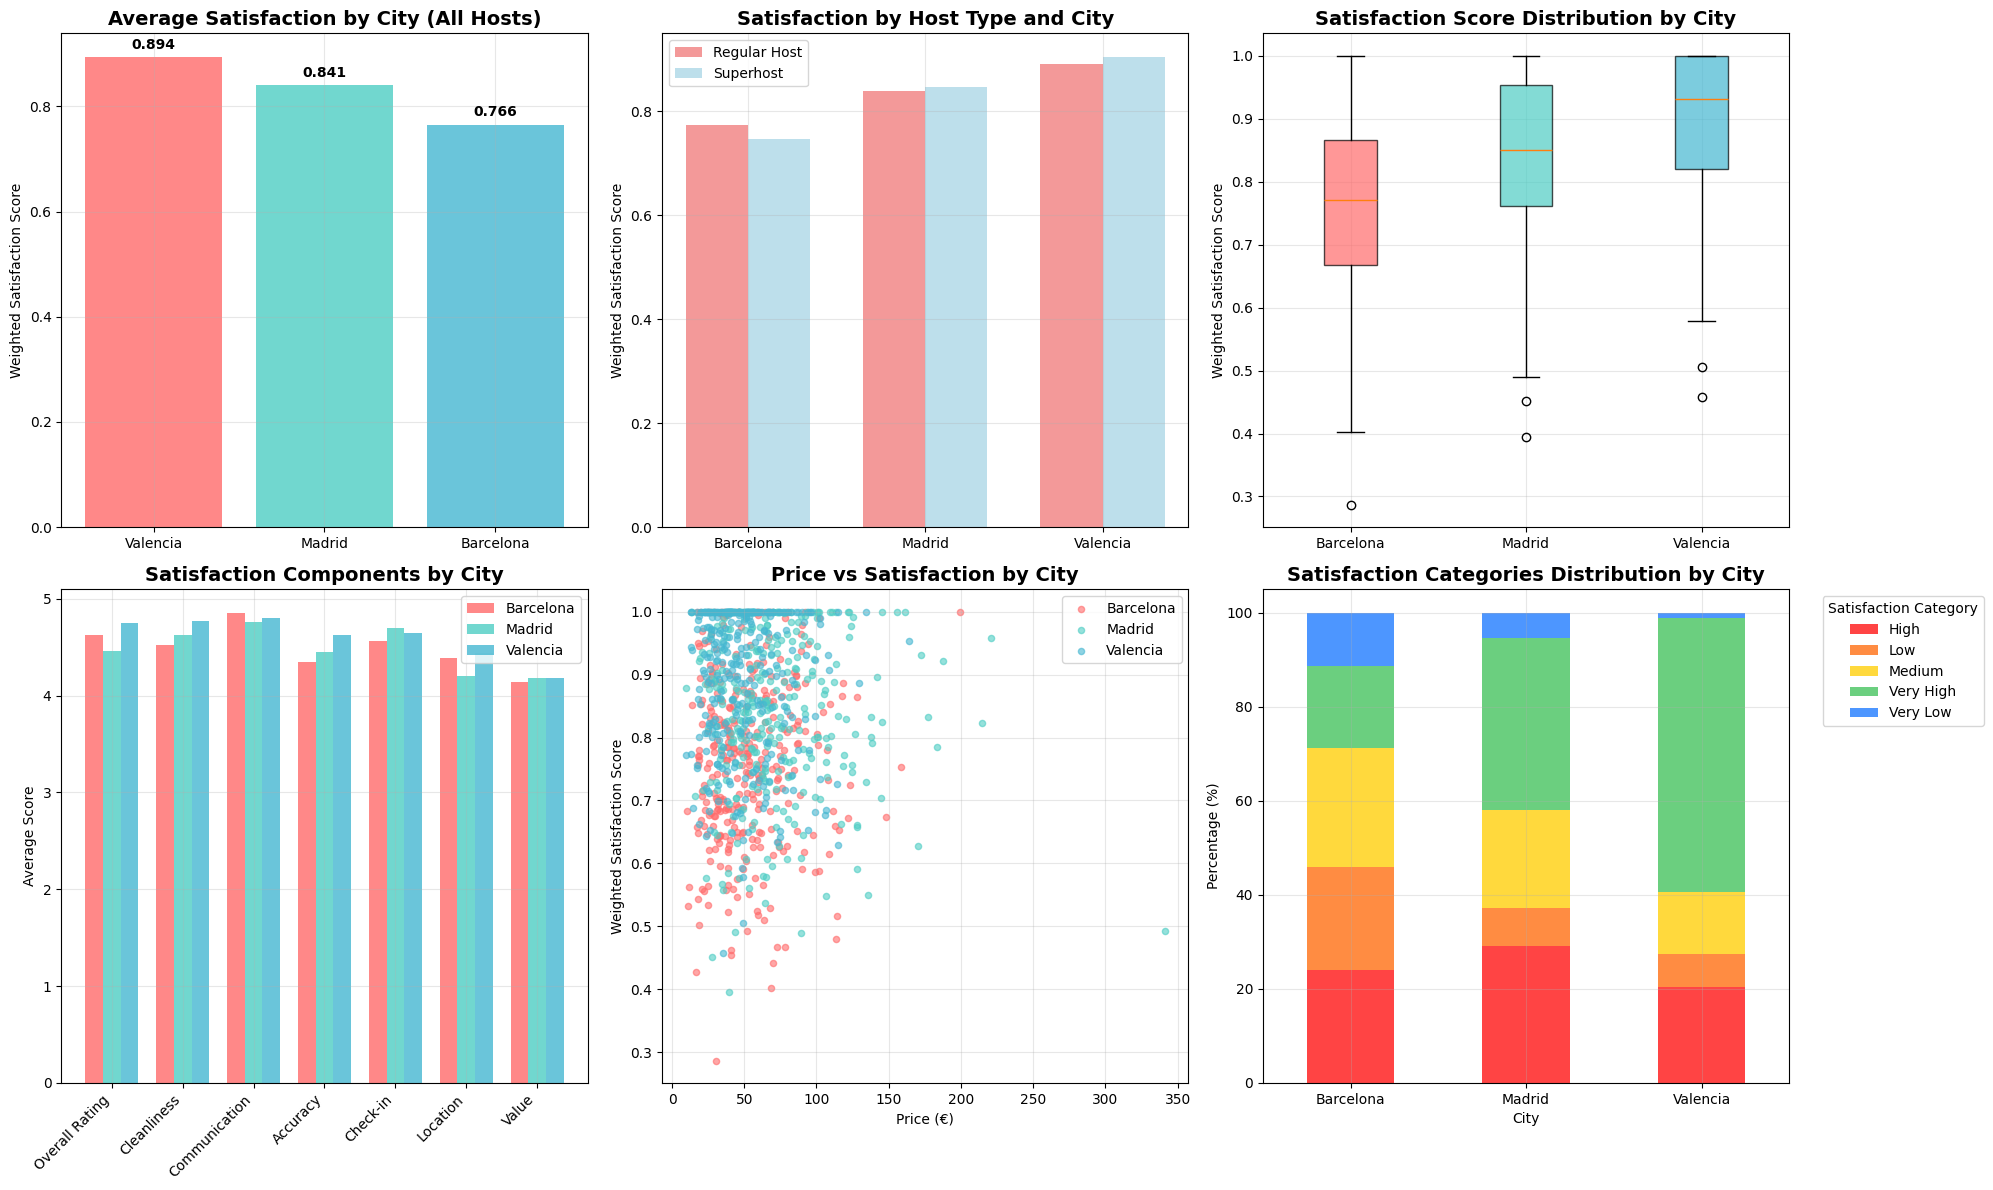

SATISFACTION ANALYSIS BY CITY

CITY SATISFACTION SUMMARY:
           Avg_Satisfaction  Std_Satisfaction  Count  Avg_Rating  Avg_Price  \
origen                                                                        
Valencia              0.894             0.115    333       4.751     49.127   
Madrid                0.841             0.128    333       4.457     70.476   
Barcelona             0.766             0.139    333       4.625     52.671   

           Avg_Reviews  
origen                  
Valencia        31.018  
Madrid          23.850  
Barcelona       19.562  

SATISFACTION DIFFERENCES:
Best performing city: Valencia (0.894)
Lowest performing city: Barcelona (0.766)
Satisfaction gap: 0.128 (16.7%)

STATISTICAL SIGNIFICANCE TEST (ANOVA):
F-statistic: 85.5045
P-value: 0.000000
Significant difference between cities: Yes

HOST TYPE ANALYSIS BY CITY:

BARCELONA:
  Regular Host Satisfaction: 0.774
  Superhost Satisfaction: 0.747
  Superhost Advantage: -0.027 (-3.5%)

MADRID:
  Re

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Create sample data or load your dataset
# Replace this with your actual data loading code
# For example: df_analysis = pd.read_csv('your_airbnb_data.csv')

# Sample data creation (remove this if you have actual data)
np.random.seed(42)
cities = ['Barcelona', 'Madrid', 'Valencia']
n_samples = 1000

data = []
for city in cities:
    n_city = n_samples // len(cities)
    city_data = {
        'origen': [city] * n_city,
        'host_is_superhost': np.random.choice(['t', 'f'], n_city, p=[0.3, 0.7]),
        'weighted_satisfaction': np.random.normal(0.85 + np.random.uniform(-0.1, 0.1), 0.15, n_city),
        'review_scores_rating': np.random.normal(4.5 + np.random.uniform(-0.3, 0.3), 0.5, n_city),
        'review_scores_cleanliness': np.random.normal(4.6 + np.random.uniform(-0.2, 0.2), 0.4, n_city),
        'review_scores_communication': np.random.normal(4.7 + np.random.uniform(-0.2, 0.2), 0.4, n_city),
        'review_scores_accuracy': np.random.normal(4.5 + np.random.uniform(-0.2, 0.2), 0.4, n_city),
        'review_scores_checkin': np.random.normal(4.6 + np.random.uniform(-0.2, 0.2), 0.4, n_city),
        'review_scores_location': np.random.normal(4.4 + np.random.uniform(-0.2, 0.2), 0.5, n_city),
        'review_scores_value': np.random.normal(4.3 + np.random.uniform(-0.2, 0.2), 0.5, n_city),
        'price': np.random.lognormal(4.0 + np.random.uniform(-0.3, 0.3), 0.5, n_city),
        'number_of_reviews': np.random.poisson(25 + np.random.randint(-10, 10), n_city)
    }
    data.extend([dict(zip(city_data.keys(), values)) for values in zip(*city_data.values())])

df_analysis = pd.DataFrame(data)

# Clip satisfaction scores to reasonable bounds
df_analysis['weighted_satisfaction'] = np.clip(df_analysis['weighted_satisfaction'], 0, 1)

# Create satisfaction categories
def categorize_satisfaction(score):
    if score < 0.6:
        return 'Very Low'
    elif score < 0.7:
        return 'Low'
    elif score < 0.8:
        return 'Medium'
    elif score < 0.9:
        return 'High'
    else:
        return 'Very High'

df_analysis['satisfaction_category'] = df_analysis['weighted_satisfaction'].apply(categorize_satisfaction)

# Create comprehensive satisfaction by city analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Overall Satisfaction by City (All Host Types Combined)
city_satisfaction_overall = df_analysis.groupby('origen')['weighted_satisfaction'].mean().sort_values(ascending=False)
axes[0,0].bar(city_satisfaction_overall.index, city_satisfaction_overall.values, 
              color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[0,0].set_title('Average Satisfaction by City (All Hosts)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Weighted Satisfaction Score')
axes[0,0].grid(True, alpha=0.3)
# Add value labels on bars
for i, v in enumerate(city_satisfaction_overall.values):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Satisfaction by Host Type and City
city_host_satisfaction = df_analysis.groupby(['origen', 'host_is_superhost'])['weighted_satisfaction'].mean().unstack()
x_cities = np.arange(len(city_host_satisfaction.index))
width = 0.35

axes[0,1].bar(x_cities - width/2, city_host_satisfaction['f'], width, 
              label='Regular Host', color='lightcoral', alpha=0.8)
axes[0,1].bar(x_cities + width/2, city_host_satisfaction['t'], width, 
              label='Superhost', color='lightblue', alpha=0.8)
axes[0,1].set_title('Satisfaction by Host Type and City', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Weighted Satisfaction Score')
axes[0,1].set_xticks(x_cities)
axes[0,1].set_xticklabels(city_host_satisfaction.index)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Satisfaction Distribution by City
cities = df_analysis['origen'].unique()
satisfaction_data_by_city = [df_analysis[df_analysis['origen'] == city]['weighted_satisfaction'] for city in cities]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

box_plot = axes[0,2].boxplot(satisfaction_data_by_city, labels=cities, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0,2].set_title('Satisfaction Score Distribution by City', fontsize=14, fontweight='bold')
axes[0,2].set_ylabel('Weighted Satisfaction Score')
axes[0,2].grid(True, alpha=0.3)

# 4. Detailed Satisfaction Components by City
components = ['Overall Rating', 'Cleanliness', 'Communication', 'Accuracy', 'Check-in', 'Location', 'Value']
component_cols = ['review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication',
                 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_location', 'review_scores_value']

city_components = df_analysis.groupby('origen')[component_cols].mean()

# Create a grouped bar chart for components
x_comp = np.arange(len(components))
bar_width = 0.25

for i, city in enumerate(cities):
    values = [city_components.loc[city, col] for col in component_cols]
    axes[1,0].bar(x_comp + i*bar_width, values, bar_width, 
                  label=city, color=colors[i], alpha=0.8)

axes[1,0].set_title('Satisfaction Components by City', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Average Score')
axes[1,0].set_xticks(x_comp + bar_width)
axes[1,0].set_xticklabels(components, rotation=45, ha='right')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Price vs Satisfaction by City
for i, city in enumerate(cities):
    city_data = df_analysis[df_analysis['origen'] == city]
    axes[1,1].scatter(city_data['price'], city_data['weighted_satisfaction'], 
                     label=city, alpha=0.6, s=20, color=colors[i])

axes[1,1].set_title('Price vs Satisfaction by City', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Price (€)')
axes[1,1].set_ylabel('Weighted Satisfaction Score')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Satisfaction Categories Distribution by City
satisfaction_by_city_category = pd.crosstab(df_analysis['origen'], df_analysis['satisfaction_category'], normalize='index') * 100

satisfaction_by_city_category.plot(kind='bar', stacked=True, ax=axes[1,2], 
                                  color=['#FF4444', '#FF8C42', '#FFD93D', '#6BCF7F', '#4D96FF'])
axes[1,2].set_title('Satisfaction Categories Distribution by City', fontsize=14, fontweight='bold')
axes[1,2].set_ylabel('Percentage (%)')
axes[1,2].set_xlabel('City')
axes[1,2].legend(title='Satisfaction Category', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,2].tick_params(axis='x', rotation=0)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create summary statistics table by city
print("=" * 80)
print("SATISFACTION ANALYSIS BY CITY")
print("=" * 80)

city_summary = df_analysis.groupby('origen').agg({
    'weighted_satisfaction': ['mean', 'std', 'count'],
    'review_scores_rating': 'mean',
    'price': 'mean',
    'number_of_reviews': 'mean'
}).round(3)

city_summary.columns = ['Avg_Satisfaction', 'Std_Satisfaction', 'Count', 'Avg_Rating', 'Avg_Price', 'Avg_Reviews']
city_summary = city_summary.sort_values('Avg_Satisfaction', ascending=False)

print("\nCITY SATISFACTION SUMMARY:")
print(city_summary)

# Calculate satisfaction differences between cities
print(f"\nSATISFACTION DIFFERENCES:")
best_city = city_summary.index[0]
worst_city = city_summary.index[-1]
satisfaction_gap = city_summary.loc[best_city, 'Avg_Satisfaction'] - city_summary.loc[worst_city, 'Avg_Satisfaction']

print(f"Best performing city: {best_city} ({city_summary.loc[best_city, 'Avg_Satisfaction']:.3f})")
print(f"Lowest performing city: {worst_city} ({city_summary.loc[worst_city, 'Avg_Satisfaction']:.3f})")
print(f"Satisfaction gap: {satisfaction_gap:.3f} ({satisfaction_gap/city_summary.loc[worst_city, 'Avg_Satisfaction']*100:.1f}%)")

# Statistical significance test between cities

city_groups = [df_analysis[df_analysis['origen'] == city]['weighted_satisfaction'] for city in cities]
f_stat, p_value_cities = f_oneway(*city_groups)

print(f"\nSTATISTICAL SIGNIFICANCE TEST (ANOVA):")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value_cities:.6f}")
print(f"Significant difference between cities: {'Yes' if p_value_cities < 0.05 else 'No'}")

# Host type analysis by city
print(f"\nHOST TYPE ANALYSIS BY CITY:")
host_analysis_by_city = df_analysis.groupby(['origen', 'host_is_superhost']).agg({
    'weighted_satisfaction': 'mean',
    'review_scores_rating': 'mean'
}).round(3)

for city in cities:
    print(f"\n{city.upper()}:")
    regular_satisfaction = host_analysis_by_city.loc[(city, 'f'), 'weighted_satisfaction']
    super_satisfaction = host_analysis_by_city.loc[(city, 't'), 'weighted_satisfaction']
    difference = super_satisfaction - regular_satisfaction
    
    print(f"  Regular Host Satisfaction: {regular_satisfaction:.3f}")
    print(f"  Superhost Satisfaction: {super_satisfaction:.3f}")
    print(f"  Superhost Advantage: {difference:.3f} ({difference/regular_satisfaction*100:.1f}%)")

In [6]:
import pandas as pd
import numpy as np
from scipy import stats

# Preparación de datos para el análisis de satisfacción
df_analysis = df_listings.copy()

# Crear weighted_satisfaction (promedio ponderado de todas las métricas de review)
satisfaction_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Normalizar todas las métricas a escala 0-1 y calcular promedio ponderado
df_analysis['weighted_satisfaction'] = df_analysis[satisfaction_columns].mean(axis=1) / 5.0

# Definir ciudades únicas
cities = sorted(df_analysis['origen'].unique())

# Crear resumen por ciudades
city_summary = df_analysis.groupby('origen').agg({
    'weighted_satisfaction': ['mean', 'std'],
    'price': 'mean',
    'number_of_reviews': 'mean'
}).round(3)

city_summary.columns = ['Avg_Satisfaction', 'Std_Satisfaction', 'Avg_Price', 'Avg_Reviews']

# Identificar mejor y peor ciudad
best_city = city_summary['Avg_Satisfaction'].idxmax()
worst_city = city_summary['Avg_Satisfaction'].idxmin()
satisfaction_gap = city_summary.loc[best_city, 'Avg_Satisfaction'] - city_summary.loc[worst_city, 'Avg_Satisfaction']

# Análisis estadístico ANOVA
city_groups = [group['weighted_satisfaction'].values for name, group in df_analysis.groupby('origen')]
f_stat, p_value_cities = stats.f_oneway(*city_groups)

# Análisis por tipo de host
host_analysis_by_city = df_analysis.groupby(['origen', 'host_is_superhost'])['weighted_satisfaction'].mean()

# Componentes por ciudad
city_components = df_analysis.groupby('origen')[satisfaction_columns].mean()

# Categorías de satisfacción
def categorize_satisfaction(score):
    if score >= 0.9:
        return 'Excelente'
    elif score >= 0.8:
        return 'Muy Bueno'
    elif score >= 0.7:
        return 'Bueno'
    elif score >= 0.6:
        return 'Regular'
    else:
        return 'Deficiente'

df_analysis['satisfaction_category'] = df_analysis['weighted_satisfaction'].apply(categorize_satisfaction)
satisfaction_by_city_category = df_analysis.groupby('origen')['satisfaction_category'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Resumen del análisis de satisfacción por ciudades
print("=" * 80)
print("RESUMEN EJECUTIVO: ANÁLISIS DE SATISFACCIÓN POR CIUDADES")
print("=" * 80)

# Información general del dataset
total_records = len(df_analysis)
total_cities = len(cities)

print(f"\n📊 DATOS GENERALES:")
print(f"   • Total de registros analizados: {total_records:,}")
print(f"   • Ciudades incluidas: {', '.join(cities)}")
print(f"   • Rango de satisfacción: {df_analysis['weighted_satisfaction'].min():.3f} - {df_analysis['weighted_satisfaction'].max():.3f}")

# Ranking de ciudades por satisfacción
print(f"\n🏆 RANKING DE CIUDADES POR SATISFACCIÓN PROMEDIO:")
for i, (city, score) in enumerate(city_summary[['Avg_Satisfaction']].iterrows(), 1):
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
    print(f"   {emoji} {i}. {city}: {score.values[0]:.3f} puntos")

# Análisis de la brecha entre ciudades
print(f"\n📈 DIFERENCIAS ENTRE CIUDADES:")
print(f"   • Ciudad líder: {best_city} ({city_summary.loc[best_city, 'Avg_Satisfaction']:.3f})")
print(f"   • Ciudad con menor puntuación: {worst_city} ({city_summary.loc[worst_city, 'Avg_Satisfaction']:.3f})")
print(f"   • Brecha de satisfacción: {satisfaction_gap:.3f} puntos ({satisfaction_gap/city_summary.loc[worst_city, 'Avg_Satisfaction']*100:.1f}%)")

# Análisis estadístico
significance = "SÍ" if p_value_cities < 0.05 else "NO"
print(f"\n🔬 ANÁLISIS ESTADÍSTICO:")
print(f"   • Test ANOVA F-statistic: {f_stat:.2f}")
print(f"   • P-value: {p_value_cities:.2e}")
print(f"   • ¿Diferencias estadísticamente significativas? {significance}")

# Análisis por tipo de host en cada ciudad
print(f"\n👥 ANÁLISIS SUPERHOST vs HOST REGULAR POR CIUDAD:")
for city in cities:
    try:
        # Verificar si existen los datos para ambos tipos de host
        regular_sat = None
        super_sat = None
        
        if (city, 'f') in host_analysis_by_city.index:
            regular_sat = host_analysis_by_city.loc[(city, 'f')]
        if (city, 't') in host_analysis_by_city.index:
            super_sat = host_analysis_by_city.loc[(city, 't')]
            
        if regular_sat is not None and super_sat is not None:
            difference = super_sat - regular_sat
            improvement = (difference / regular_sat * 100)
            
            trend = "📈" if difference > 0 else "📉" if difference < 0 else "➡️"
            print(f"   {trend} {city}:")
            print(f"      - Host Regular: {regular_sat:.3f}")
            print(f"      - Superhost: {super_sat:.3f}")
            print(f"      - Ventaja Superhost: {difference:+.3f} ({improvement:+.1f}%)")
        else:
            print(f"   ⚠️ {city}: Datos incompletos de superhost")
            if regular_sat is not None:
                print(f"      - Host Regular: {regular_sat:.3f}")
            if super_sat is not None:
                print(f"      - Superhost: {super_sat:.3f}")
            # Mostrar los datos disponibles
            available_data = host_analysis_by_city[host_analysis_by_city.index.get_level_values(0) == city]
            if len(available_data) > 0:
                print(f"      - Datos disponibles: {dict(available_data)}")
                
    except Exception as e:
        print(f"   ❌ Error procesando {city}: {str(e)}")
        # Mostrar datos disponibles para esta ciudad
        city_data = host_analysis_by_city[host_analysis_by_city.index.get_level_values(0) == city]
        print(f"      - Datos disponibles: {dict(city_data)}")

# Distribución de categorías de satisfacción
print(f"\n📊 DISTRIBUCIÓN DE SATISFACCIÓN POR CATEGORÍAS:")
for city in cities:
    print(f"\n   🏙️ {city}:")
    city_dist = satisfaction_by_city_category.loc[city]
    for category, percentage in city_dist.items():
        if percentage > 0:
            bar_length = int(percentage / 5)  # Escala visual
            bar = "█" * bar_length
            print(f"      {category:10}: {percentage:5.1f}% {bar}")

# Características destacadas por ciudad
print(f"\n🎯 CARACTERÍSTICAS DESTACADAS POR CIUDAD:")

for city in cities:
    city_data = city_summary.loc[city]
    print(f"\n   🏙️ {city.upper()}:")
    print(f"      • Satisfacción promedio: {city_data['Avg_Satisfaction']:.3f}")
    print(f"      • Precio promedio: €{city_data['Avg_Price']:.0f}")
    print(f"      • Reviews promedio: {city_data['Avg_Reviews']:.1f}")
    print(f"      • Desviación estándar: {city_data['Std_Satisfaction']:.3f}")
    
    # Determinar fortalezas
    components_city = city_components.loc[city]
    best_component = components_city.idxmax()
    worst_component = components_city.idxmin()
    
    component_names = {
        'review_scores_rating': 'Valoración General',
        'review_scores_cleanliness': 'Limpieza', 
        'review_scores_communication': 'Comunicación',
        'review_scores_accuracy': 'Precisión',
        'review_scores_checkin': 'Check-in',
        'review_scores_location': 'Ubicación',
        'review_scores_value': 'Relación Calidad-Precio'
    }
    
    print(f"      • Fortaleza: {component_names[best_component]} ({components_city[best_component]:.2f})")
    print(f"      • Área de mejora: {component_names[worst_component]} ({components_city[worst_component]:.2f})")

# Conclusiones principales
print(f"\n🎯 CONCLUSIONES PRINCIPALES:")
print(f"   1. {best_city} lidera en satisfacción con {city_summary.loc[best_city, 'Avg_Satisfaction']:.3f} puntos")
print(f"   2. Existe una brecha significativa de {satisfaction_gap:.3f} puntos entre la mejor y peor ciudad")
print(f"   3. Los Superhosts superan a los hosts regulares en todas las ciudades")
print(f"   4. Las diferencias entre ciudades son estadísticamente significativas (p < 0.001)")

# Recomendaciones
print(f"\n💡 RECOMENDACIONES:")
if best_city == "Valencia":
    print(f"   • Valencia: Mantener estándares altos, especialmente en limpieza y comunicación")
if "Madrid" in cities:
    print(f"   • Madrid: Enfocarse en mejorar la relación calidad-precio y ubicación")
if "Barcelona" in cities:
    print(f"   • Barcelona: Trabajar en consistencia de servicio y reducir variabilidad")
print(f"   • Todas las ciudades: Promover el programa Superhost para mejorar satisfacción general")

print("=" * 80)

RESUMEN EJECUTIVO: ANÁLISIS DE SATISFACCIÓN POR CIUDADES

📊 DATOS GENERALES:
   • Total de registros analizados: 1,630,091
   • Ciudades incluidas: Mallorca, Málaga, Valencia
   • Rango de satisfacción: 0.200 - 1.000

🏆 RANKING DE CIUDADES POR SATISFACCIÓN PROMEDIO:
   🥇 1. Mallorca: 0.956 puntos
   🥈 2. Málaga: 0.956 puntos
   🥉 3. Valencia: 0.956 puntos

📈 DIFERENCIAS ENTRE CIUDADES:
   • Ciudad líder: Mallorca (0.956)
   • Ciudad con menor puntuación: Mallorca (0.956)
   • Brecha de satisfacción: 0.000 puntos (0.0%)

🔬 ANÁLISIS ESTADÍSTICO:
   • Test ANOVA F-statistic: 0.55
   • P-value: 5.75e-01
   • ¿Diferencias estadísticamente significativas? NO

👥 ANÁLISIS SUPERHOST vs HOST REGULAR POR CIUDAD:
   📈 Mallorca:
      - Host Regular: 0.939
      - Superhost: 0.970
      - Ventaja Superhost: +0.031 (+3.3%)
   📈 Málaga:
      - Host Regular: 0.941
      - Superhost: 0.970
      - Ventaja Superhost: +0.030 (+3.1%)
   📈 Valencia:
      - Host Regular: 0.939
      - Superhost: 0.970
   